# classification-23

## What's new:

1-

section: 3


## next step:

1-


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, TimeDistributed, Lambda, RepeatVector, Dropout, \
    BatchNormalization
from tensorflow.keras import Input, layers, models, callbacks, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks

from tensorflow import keras
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, find_peaks, peak_prominences

import datetime
import joblib
import json
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-12-16 18:03:58.495860: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 18:03:58.631328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [3]:
df.shape

(179856, 10)

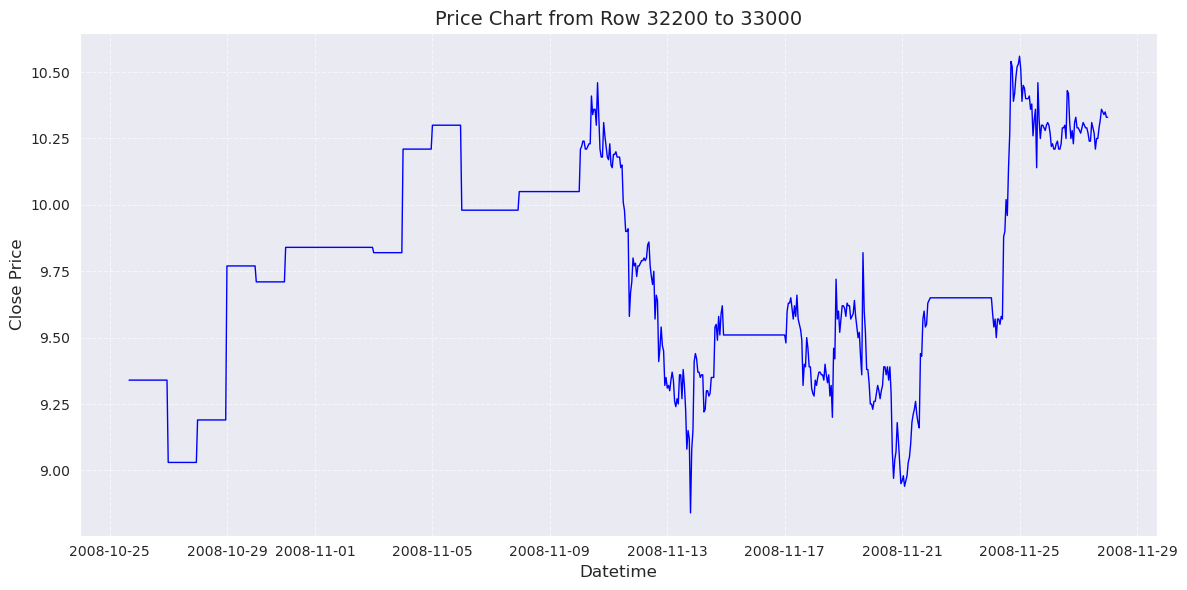

In [4]:
# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [6]:
def label_reversal_points(
        close,
        high=None,
        low=None,
        smoothing_window=31,
        polyorder=3,
        base_prom_factor=0.02,
        distance=3,
        snap_window=5,
        min_dev_pct=0.0015,  # 0.15% minimum leg size
        min_dev_sigma=2.0,  # >= 2x local abs-return EMA
        vol_window=100,  # EMA window for local volatility
        verbose=False
):
    """
    Label reversal points with improved accuracy.

    Returns labels array of length n where:
    0 = none, 1 = valley, 2 = peak.

    Tips:
    - For best accuracy, pass high/low arrays from your OHLCV.
      Example: label_reversal_points(df['CLOSE'], df['HIGH'], df['LOW'])
    - Tune min_dev_pct / min_dev_sigma to be stricter or looser on swing size.
    """
    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # Interpolate NaNs if any
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # Helper: simple EMA for local abs-return volatility
    def ema(x, span):
        x = np.asarray(x, dtype=float)
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    # Local volatility in price terms via EMA of absolute returns
    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close  # convert to price units

    # Smoothing to get robust candidates
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    # Base prominence threshold
    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    # Candidate peaks/valleys on smoothed
    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    # Prominences for tie-breaking
    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    # Combine
    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i]) if peak_prom.size else 0.0))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i]) if val_prom.size else 0.0))
    candidates.sort(key=lambda x: x[0])

    if not candidates:
        labels = np.zeros(n, dtype=int)
        # still mark edges for completeness
        labels[0] = 1 if close[1] > close[0] else 2
        labels[-1] = 1 if close[-1] > close[-2] else 2
        return labels

    # Enforce alternation (remove weaker when two same-type neighbors)
    def enforce_alternation(ext):
        ext = ext[:]  # list of (idx, typ, prom)
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    # drop the smaller prominence
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # SNAP: move each extreme to the true local extremum on raw close (or HIGH/LOW)
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            if typ == 2:  # peak
                j = np.argmax(np.asarray(high[L:R], dtype=float))
            else:  # valley
                j = np.argmin(np.asarray(low[L:R], dtype=float))
        else:
            if typ == 2:
                j = np.argmax(close[L:R])
            else:
                j = np.argmin(close[L:R])
        return L + int(j)

    snapped = []
    seen_at = {}  # avoid duplicate indices by keeping stronger prominence
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        key = (j, typ)
        if key not in seen_at or pr > seen_at[key][2]:
            seen_at[key] = (j, typ, pr)
    snapped = sorted(seen_at.values(), key=lambda x: x[0])

    # Enforce alternation again after snapping
    snapped = enforce_alternation(snapped)

    # Filter micro-legs using adaptive threshold (min % move and sigma*local_vol)
    pruned = []
    for idx, typ, pr in snapped:
        if not pruned:
            pruned.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = pruned[-1]
        # time spacing
        if idx - prev_idx < distance:
            # keep the more prominent of the two
            if pr > prev_pr:
                pruned[-1] = (idx, typ, pr)
            continue
        leg = abs(close[idx] - close[prev_idx])
        # thresholds at both ends
        thr = max(min_dev_pct * close[prev_idx],
                  min_dev_sigma * max(local_vol_price[prev_idx], 1e-12))
        thr = max(thr, max(min_dev_pct * close[idx],
                           min_dev_sigma * max(local_vol_price[idx], 1e-12)))
        if leg >= thr:
            pruned.append((idx, typ, pr))
        else:
            # too small swing → drop the later point
            continue

    # One more alternation pass (paranoid) and spacing check
    pruned = enforce_alternation(pruned)
    final_ext = []
    for idx, typ, pr in pruned:
        if final_ext and idx - final_ext[-1][0] < distance:
            # keep stronger
            if pr > final_ext[-1][2]:
                final_ext[-1] = (idx, typ, pr)
        else:
            final_ext.append((idx, typ, pr))

    # Build labels
    labels = np.zeros(n, dtype=int)
    for idx, typ, _ in final_ext:
        labels[idx] = typ

    # Mark edges as trend boundaries for continuity
    if labels[0] == 0:
        labels[0] = 1 if close[min(1, n - 1)] > close[0] else 2
    if labels[-1] == 0 and n >= 2:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    if verbose:
        c0 = int((labels == 0).sum())
        c1 = int((labels == 1).sum())
        c2 = int((labels == 2).sum())
        print(f"labels -> 0:{c0}  1:{c1}  2:{c2}  (extrema kept: {len(final_ext)})")

    return labels


In [7]:
# baseline (close-only)
df_model['Label'] = label_reversal_points(df_model['CLOSE'].values, verbose=True)

# inspect counts
print(df_model['Label'].value_counts())

labels -> 0:144229  1:1063  2:1064  (extrema kept: 2125)
Label
0    144229
2      1064
1      1063
Name: count, dtype: int64


In [8]:
# Display label distribution in df_model
label_counts = df_model['Label'].value_counts().sort_index()
label_percentages = (df_model['Label'].value_counts(normalize=True) * 100).sort_index()

print("Label Distribution in df_model:")
print("-" * 40)
for label in sorted(df_model['Label'].unique()):
    count = label_counts[label]
    percentage = label_percentages[label]
    print(f"Class {label}: {count:,} rows ({percentage:.2f}%)")
print("-" * 40)
print(f"Total rows: {len(df_model):,}")


Label Distribution in df_model:
----------------------------------------
Class 0: 144,229 rows (98.55%)
Class 1: 1,063 rows (0.73%)
Class 2: 1,064 rows (0.73%)
----------------------------------------
Total rows: 146,356


In [9]:
def plot_labeled_candles(df_model, n=1000):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df_model.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



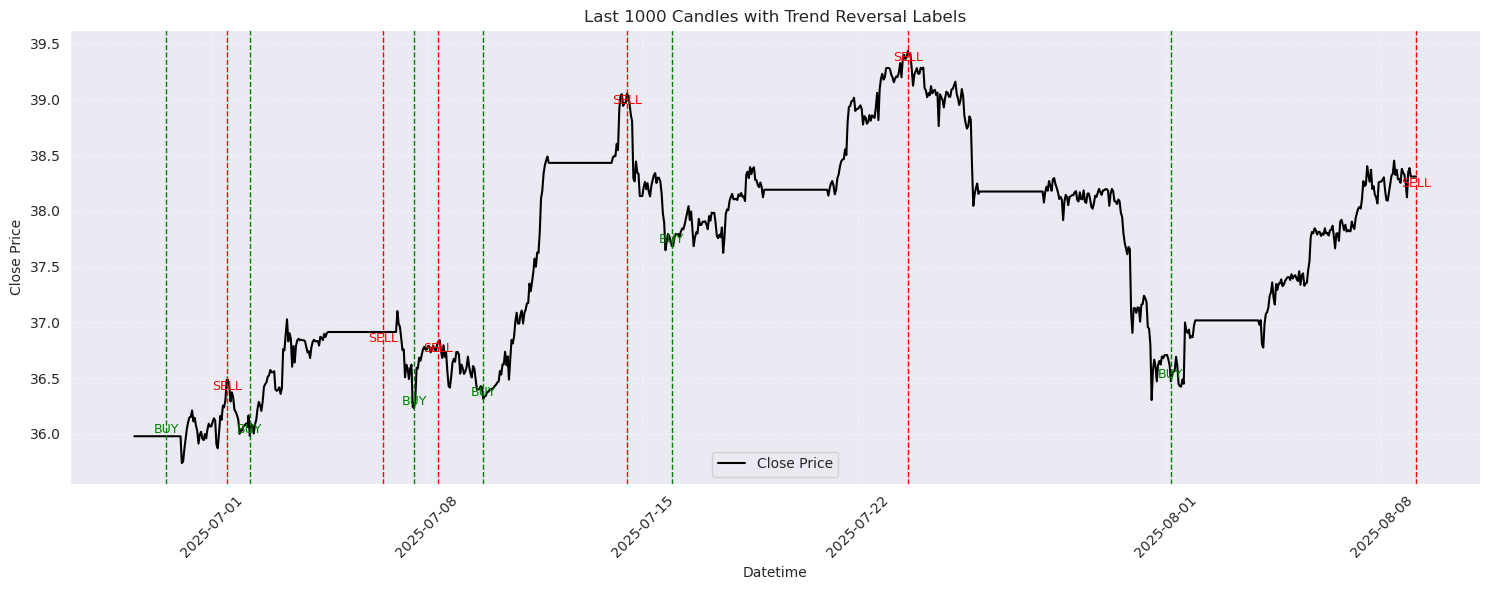

In [10]:
plot_labeled_candles(df_model)

In [11]:
# --------------------------
# Part 3 — Chronological splitting (70% train, 15% val, 15% test)
# --------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

WINDOW_SIZE = 120
FORECAST_HORIZON = 5
FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
BATCH_SIZE = 256

# Safety checks
assert 'df_model' in globals(), "df_model is not defined. Please load df_model before running this cell."
assert all(feat in df_model.columns for feat in FEATURES), f"Not all FEATURES found in df_model columns: {FEATURES}"
assert 'Label' in df_model.columns, "df_model must contain a 'Label' column."

# Ensure chronological order by DATETIME (robustness)
if 'DATETIME' in df_model.columns:
    df_model = df_model.copy()
    df_model['DATETIME'] = pd.to_datetime(df_model['DATETIME'])
    df_model = df_model.sort_values('DATETIME', ascending=True).reset_index(drop=True)

# Basic meta
n_rows = len(df_model)
print(f"Total rows in df_model: {n_rows}")

# Chronological split boundaries
train_end = int(np.floor(0.70 * n_rows))
val_end = int(np.floor(0.85 * n_rows))  # 70% -> 85% -> 100%

# Slice datasets (pure chronological, no shuffling)
train_df = df_model.iloc[:train_end].reset_index(drop=True)
val_df = df_model.iloc[train_end:val_end].reset_index(drop=True)
test_df = df_model.iloc[val_end:].reset_index(drop=True)

print(f"Train rows : {len(train_df)} (0:{train_end})")
print(f"Val rows   : {len(val_df)} ({train_end}:{val_end})")
print(f"Test rows  : {len(test_df)} ({val_end}:{n_rows})")
print("")

Total rows in df_model: 146356
Train rows : 102449 (0:102449)
Val rows   : 21953 (102449:124402)
Test rows  : 21954 (124402:146356)



In [12]:
# Part 4 — Scaling using only training data (StandardScaler)
# At the end we print variables useful for Part 5 (Imbalance handling)
# --- Prepare arrays of features for scaler and later sequence building ---

X_train_raw = train_df[FEATURES].astype(float).copy()  # DataFrame
X_val_raw = val_df[FEATURES].astype(float).copy()
X_test_raw = test_df[FEATURES].astype(float).copy()

# --- Fit scaler on training features ONLY ---
scaler = StandardScaler()
scaler.fit(X_train_raw.values)  # fit on numpy array from training set only

# Transform all splits using the training-fitted scaler
X_train_scaled = scaler.transform(X_train_raw.values)  # numpy array shape (n_train, n_features)
X_val_scaled = scaler.transform(X_val_raw.values)
X_test_scaled = scaler.transform(X_test_raw.values)

# If user later wants DataFrames back (with same columns), create them:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=FEATURES)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=FEATURES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=FEATURES)

# --- Label arrays for imbalance handling (these are per-row labels) ---
y_train_labels = train_df['Label'].astype(int).values
y_val_labels = val_df['Label'].astype(int).values
y_test_labels = test_df['Label'].astype(int).values

# --- Basic class distribution info (useful for imbalance handling) ---
unique_classes = np.array(sorted(df_model['Label'].dropna().unique())).astype(int)

train_class_counts = {int(c): int((y_train_labels == c).sum()) for c in unique_classes}
val_class_counts = {int(c): int((y_val_labels == c).sum()) for c in unique_classes}
test_class_counts = {int(c): int((y_test_labels == c).sum()) for c in unique_classes}

train_total = len(y_train_labels)
val_total = len(y_val_labels)
test_total = len(y_test_labels)

train_class_percent = {c: (count / train_total) * 100.0 for c, count in train_class_counts.items()}

# --- Compute initial class weights (sklearn balanced weighting) on the training labels
# This gives a starting point; given extreme imbalance you will likely combine resampling + weights.
classes_for_weights = np.array(sorted(np.unique(y_train_labels)))
class_weights = compute_class_weight(class_weight='balanced', classes=classes_for_weights, y=y_train_labels)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes_for_weights, class_weights)}

# --------------------------
# PRINT the variables required for Part 5 (Imbalance handling)
# These include: indices/splits, raw counts & percentages, and the scaler (fitted)
# --------------------------
print("\n=== Variables & summaries for Part 5 (Imbalance handling) ===\n")

print("1) Split indices (chronological slice positions):")
print(f"   train_end index: {train_end}")
print(f"   val_end   index: {val_end}\n")

print("2) Shapes of splits:")
print(f"   train_df shape: {train_df.shape}")
print(f"   val_df   shape: {val_df.shape}")
print(f"   test_df  shape: {test_df.shape}\n")

print("3) Label distribution (counts) in TRAIN set:")
for c, cnt in train_class_counts.items():
    pct = train_class_percent[c]
    print(f"   Class {c}: {cnt} samples ({pct:.6f}%)")
print(f"   -> Total training samples = {train_total}\n")

print("4) Label distribution (counts) in VAL set:")
for c, cnt in val_class_counts.items():
    print(f"   Class {c}: {cnt} samples")
print(f"   -> Total validation samples = {val_total}\n")

print("5) Label distribution (counts) in TEST set:")
for c, cnt in test_class_counts.items():
    print(f"   Class {c}: {cnt} samples")
print(f"   -> Total test samples = {test_total}\n")

print("6) Initial class_weight (sklearn 'balanced') computed from TRAIN labels:")
for c, w in class_weight_dict.items():
    print(f"   Class {c}: weight = {w:.6f}")
print(
    "   (These are a starting reference; with extreme imbalance you'll likely need resampling + specialized losses.)\n")

print("7) Objects/arrays you will likely need for Part 5:")
print("   - y_train_labels           (numpy array of training labels)")
print("   - train_class_counts       (dict of per-class counts in train)")
print("   - class_weight_dict        (dict of computed weights from sklearn)")
print("   - X_train_scaled           (numpy array of scaled training features, shape = (n_train, n_features))")
print("   - X_val_scaled             (numpy array of scaled val features)")
print("   - X_test_scaled            (numpy array of scaled test features)")
print("   - X_train_scaled_df        (pandas DataFrame of scaled train features)")
print("   - scaler                  (fitted StandardScaler instance)")

# For convenience, also expose them in the current namespace (no-op if already present)
_train_idx = (0, train_end)
_val_idx = (train_end, val_end)
_test_idx = (val_end, n_rows)

# End of this code cell — ready for Part 5.



=== Variables & summaries for Part 5 (Imbalance handling) ===

1) Split indices (chronological slice positions):
   train_end index: 102449
   val_end   index: 124402

2) Shapes of splits:
   train_df shape: (102449, 11)
   val_df   shape: (21953, 11)
   test_df  shape: (21954, 11)

3) Label distribution (counts) in TRAIN set:
   Class 0: 101109 samples (98.692032%)
   Class 1: 670 samples (0.653984%)
   Class 2: 670 samples (0.653984%)
   -> Total training samples = 102449

4) Label distribution (counts) in VAL set:
   Class 0: 21548 samples
   Class 1: 202 samples
   Class 2: 203 samples
   -> Total validation samples = 21953

5) Label distribution (counts) in TEST set:
   Class 0: 21572 samples
   Class 1: 191 samples
   Class 2: 191 samples
   -> Total test samples = 21954

6) Initial class_weight (sklearn 'balanced') computed from TRAIN labels:
   Class 0: weight = 0.337751
   Class 1: weight = 50.969652
   Class 2: weight = 50.969652
   (These are a starting reference; with extr

In [13]:
# Part 6 — Create sequences (WINDOW_SIZE -> X, FORECAST_HORIZON -> y)
# Assumes the following variables already exist in the environment (from your Part 1-5):
# WINDOW_SIZE = 120
# FORECAST_HORIZON = 5
# FEATURES = ['OPEN','HIGH','LOW','CLOSE','TICKVOL']
# X_train_scaled, X_val_scaled, X_test_scaled    -> np.ndarray, shape: (n_rows_split, n_features)
# y_train_labels, y_val_labels, y_test_labels    -> 1D array-like, shape: (n_rows_split,)
#
# Output variables created here (ready for Part 7):
# X_train_seq, y_train_seq, y_train_seq_cat
# X_val_seq,   y_val_seq,   y_val_seq_cat
# X_test_seq,  y_test_seq,  y_test_seq_cat
#
# Notes:
# - X_*_seq shapes -> (n_sequences, WINDOW_SIZE, n_features)
# - y_*_seq shapes -> (n_sequences, FORECAST_HORIZON)  (integer labels 0/1/2)
# - y_*_seq_cat shapes -> (n_sequences, FORECAST_HORIZON, n_classes) (one-hot encoded)
# - We never cross split boundaries when creating sequences (each split processed independently).

import numpy as np
from tensorflow.keras.utils import to_categorical


# --- Helper: sliding-window sequence creator for one split ---
def create_sequences_from_split(X_split, y_split, window_size, forecast_horizon):
    """
    X_split: 2D array (n_rows, n_features)
    y_split: 1D array (n_rows,) integer labels
    Returns:
      X_seq: (n_sequences, window_size, n_features)
      y_seq: (n_sequences, forecast_horizon) ints
    """
    X_arr = np.asarray(X_split)
    y_arr = np.asarray(y_split)

    if X_arr.ndim != 2:
        raise ValueError(f"X_split must be 2D array, got shape {X_arr.shape}")
    if y_arr.ndim != 1:
        raise ValueError(f"y_split must be 1D array, got shape {y_arr.shape}")
    if X_arr.shape[0] != y_arr.shape[0]:
        raise ValueError(f"X and y must have same first-dimension length. X: {X_arr.shape[0]}, y: {y_arr.shape[0]}")

    n_rows = X_arr.shape[0]
    last_start = n_rows - window_size - forecast_horizon  # inclusive max start index
    if last_start < 0:
        # Not enough rows to construct a single sequence
        return np.empty((0, window_size, X_arr.shape[1])), np.empty((0, forecast_horizon), dtype=int)

    n_sequences = last_start + 1
    X_seq = np.empty((n_sequences, window_size, X_arr.shape[1]), dtype=X_arr.dtype)
    y_seq = np.empty((n_sequences, forecast_horizon), dtype=int)

    for i in range(n_sequences):
        X_seq[i] = X_arr[i: i + window_size]
        y_seq[i] = y_arr[i + window_size: i + window_size + forecast_horizon]

    return X_seq, y_seq


# --- Create sequences for each split ---
X_train_seq, y_train_seq = create_sequences_from_split(X_train_scaled, y_train_labels, WINDOW_SIZE, FORECAST_HORIZON)
X_val_seq, y_val_seq = create_sequences_from_split(X_val_scaled, y_val_labels, WINDOW_SIZE, FORECAST_HORIZON)
X_test_seq, y_test_seq = create_sequences_from_split(X_test_scaled, y_test_labels, WINDOW_SIZE, FORECAST_HORIZON)


# --- One-hot encode multi-step labels ---
# Determine number of classes from training labels (safe default: 3 classes {0,1,2})
classes_in_train = np.unique(y_train_seq) if y_train_seq.size > 0 else np.array([0, 1, 2])
n_classes = int(max(classes_in_train.max(), 2) + 1)  # ensures at least 3 classes (0..2)


# Convert to categorical: result shape (n_sequences, FORECAST_HORIZON, n_classes)
def one_hot_multi_step(y_seq, n_classes):
    if y_seq.size == 0:
        return np.empty((0, y_seq.shape[1], n_classes), dtype=np.float32)
    # to_categorical works on flattened array, then reshape
    flat = to_categorical(y_seq.ravel(), num_classes=n_classes)
    return flat.reshape((y_seq.shape[0], y_seq.shape[1], n_classes))


y_train_seq_cat = one_hot_multi_step(y_train_seq, n_classes)
y_val_seq_cat = one_hot_multi_step(y_val_seq, n_classes)
y_test_seq_cat = one_hot_multi_step(y_test_seq, n_classes)


# --- Useful diagnostics and prints required for Part 7 ---
def seq_stats(X_seq, y_seq, name):
    print(f"--- {name} ---")
    print(f"X_{name}_seq.shape: {X_seq.shape}")
    print(f"y_{name}_seq.shape: {y_seq.shape}")
    if y_seq.size > 0:
        flattened = y_seq.ravel()
        unique, counts = np.unique(flattened, return_counts=True)
        dist = dict(zip([int(u) for u in unique], [int(c) for c in counts]))
        total = flattened.size
        print(f"Label distribution across all forecast positions (counts): {dist}")
        print("Label distribution (percent):", {int(u): round(c / total * 100, 4) for u, c in zip(unique, counts)})
    else:
        print("No sequences (empty).")
    print()


seq_stats(X_train_seq, y_train_seq, "train")
seq_stats(X_val_seq, y_val_seq, "val")
seq_stats(X_test_seq, y_test_seq, "test")

print("n_classes (in training data / used for one-hot):", n_classes)

# Also print example shapes commonly referenced in Part 7:
print("\nVariables ready for Part 7 (Build / Train / Evaluate):")
print("X_train_seq :", X_train_seq.shape)
print("y_train_seq :", y_train_seq.shape)
print("y_train_seq_cat :", y_train_seq_cat.shape)
print("X_val_seq   :", X_val_seq.shape)
print("y_val_seq   :", y_val_seq.shape)
print("y_val_seq_cat   :", y_val_seq_cat.shape)
print("X_test_seq  :", X_test_seq.shape)
print("y_test_seq  :", y_test_seq.shape)
print("y_test_seq_cat  :", y_test_seq_cat.shape)


--- train ---
X_train_seq.shape: (102325, 120, 5)
y_train_seq.shape: (102325, 5)
Label distribution across all forecast positions (counts): {0: 504935, 1: 3345, 2: 3345}
Label distribution (percent): {0: np.float64(98.6924), 1: np.float64(0.6538), 2: np.float64(0.6538)}

--- val ---
X_val_seq.shape: (21829, 120, 5)
y_val_seq.shape: (21829, 5)
Label distribution across all forecast positions (counts): {0: 107135, 1: 1005, 2: 1005}
Label distribution (percent): {0: np.float64(98.1584), 1: np.float64(0.9208), 2: np.float64(0.9208)}

--- test ---
X_test_seq.shape: (21830, 120, 5)
y_test_seq.shape: (21830, 5)
Label distribution across all forecast positions (counts): {0: 107254, 1: 950, 2: 946}
Label distribution (percent): {0: np.float64(98.2629), 1: np.float64(0.8704), 2: np.float64(0.8667)}

n_classes (in training data / used for one-hot): 3

Variables ready for Part 7 (Build / Train / Evaluate):
X_train_seq : (102325, 120, 5)
y_train_seq : (102325, 5)
y_train_seq_cat : (102325, 5, 3)
X_

In [14]:
# Part 7 — Build, Train and Evaluate the model
# Assumes the following variables are already present in the namespace:
# X_train_seq, y_train_seq, y_train_seq_cat
# X_val_seq,   y_val_seq,   y_val_seq_cat
# X_test_seq,  y_test_seq,  y_test_seq_cat
# and constants: WINDOW_SIZE = 120, FORECAST_HORIZON = 5, FEATURES = ['OPEN','HIGH','LOW','CLOSE','TICKVOL']


from sklearn.metrics import classification_report, confusion_matrix

# Basic checks
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq_cat shape:", y_train_seq_cat.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)

N_CLASSES = y_train_seq_cat.shape[-1]  # should be 3
TIMESTEPS = y_train_seq_cat.shape[1]  # should be FORECAST_HORIZON

# ---------------------------
# Create timestep-aware sample weights to handle extreme imbalance
# ---------------------------
# Compute global class frequencies across all samples and timesteps in training set
class_counts = np.sum(y_train_seq_cat, axis=(0, 1))  # shape (n_classes,)
total_labels = np.sum(class_counts)
print("Train class counts (sum across samples and timesteps):", class_counts)

# Avoid division by zero
eps = 1e-8
# Inverse-frequency weighting (normalized)
inv_freq = (total_labels / (class_counts + eps))
# normalize so that mean weight == 1 (keeps loss scale stable)
inv_freq = inv_freq / np.mean(inv_freq)
print("Per-class inverse-frequency weights:", inv_freq)


# Build sample_weight arrays with shape (n_samples, timesteps)
def build_timestep_sample_weights(y_cat, inv_freq_array):
    # y_cat shape: (n_samples, timesteps, n_classes)
    n_samples, timesteps, n_classes = y_cat.shape
    sw = np.zeros((n_samples, timesteps), dtype=np.float32)
    # argmax to get the true class index per sample/timestep
    true_classes = np.argmax(y_cat, axis=-1)  # shape (n_samples, timesteps)
    for c in range(n_classes):
        sw[true_classes == c] = inv_freq_array[c]
    return sw


sample_weight_train = build_timestep_sample_weights(y_train_seq_cat, inv_freq)
sample_weight_val = build_timestep_sample_weights(y_val_seq_cat, inv_freq)
sample_weight_test = build_timestep_sample_weights(y_test_seq_cat, inv_freq)

print("sample_weight_train shape:", sample_weight_train.shape)

# ---------------------------
# Build the model
# Seq2Seq-ish model: Encoder LSTM -> RepeatVector -> Decoder LSTM (return_sequences=True) -> TimeDistributed(Dense)
# ---------------------------
INPUT_SHAPE = X_train_seq.shape[1:]  # (WINDOW_SIZE, n_features)
EMBED_DIM = 128
ENC_UNITS = 128
DEC_UNITS = 128
DROPOUT = 0.2

inputs = layers.Input(shape=INPUT_SHAPE, name='inputs')
# optional masking if there are padded sequences; here probably not needed but harmless
x = layers.Masking(mask_value=0.0)(inputs)
# Encoder
x = layers.Bidirectional(layers.LSTM(ENC_UNITS, return_sequences=False, dropout=DROPOUT), name='encoder_bi')(x)
# Project to embedding
x = layers.Dense(EMBED_DIM, activation='relu', name='encoder_dense')(x)
# Repeat for forecast horizon
x = layers.RepeatVector(TIMESTEPS, name='repeat_vector')(x)
# Decoder
x = layers.LSTM(DEC_UNITS, return_sequences=True, dropout=DROPOUT, name='decoder_lstm')(x)
# Optional TimeDistributed intermediate dense
x = layers.TimeDistributed(layers.Dense(64, activation='relu'), name='td_dense')(x)
# Final classification per timestep
outputs = layers.TimeDistributed(layers.Dense(N_CLASSES, activation='softmax'), name='td_softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs, name='seq2seq_reversal_classifier')
model.summary()

X_train_seq shape: (102325, 120, 5)
y_train_seq_cat shape: (102325, 5, 3)
X_val_seq shape: (21829, 120, 5)
X_test_seq shape: (21830, 120, 5)
Train class counts (sum across samples and timesteps): [504935.   3345.   3345.]
Per-class inverse-frequency weights: [0.00990412 1.49504794 1.49504794]
sample_weight_train shape: (102325, 5)


Model: "seq2seq_reversal_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 120, 5)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 120, 5)    │          0 │ inputs[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 120, 5)    │          0 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 120)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bi          │ (None, 256)       │    137,216 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense       │ (None, 128)       │     32,896 │ encoder_bi[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 5, 128)    │          0 │ encoder_dense[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 5, 128)    │    131,584 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense            │ (None, 5, 64)     │      8,256 │ decoder_lstm[0][… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_softmax          │ (None, 5, 3)      │        195 │ td_dense[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 310,147 (1.18 MB)

 Trainable params: 310,147 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# ---------------------------
# Compile
# ---------------------------
LR = 1e-3
optimizer = optimizers.Adam(learning_rate=LR)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# ---------------------------
# Callbacks
# ---------------------------

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# ---------------------------
# Fit
# Note: sample_weight for sequence outputs should be shape (n_samples, timesteps)
# ---------------------------

history = model.fit(
    X_train_seq,
    y_train_seq_cat,
    validation_data=(X_val_seq, y_val_seq_cat, sample_weight_val),
    epochs=200,
    batch_size=BATCH_SIZE,
    callbacks=[es, reduce_lr],
    sample_weight=sample_weight_train,
    verbose=1
)

print("\nTRAINING COMPLETE!")


Epoch 1/200


2025-12-16 18:05:15.891027: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


400/400 ━━━━━━━━━━━━━━━━━━━━ 96s 230ms/step - accuracy: 0.4859 - loss: 0.0318 - val_accuracy: 0.4129 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 2/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 92s 231ms/step - accuracy: 0.4356 - loss: 0.0315 - val_accuracy: 0.3208 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 3/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 92s 230ms/step - accuracy: 0.4499 - loss: 0.0313 - val_accuracy: 0.2499 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 4/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 92s 231ms/step - accuracy: 0.4319 - loss: 0.0311 - val_accuracy: 0.1312 - val_loss: 0.0397 - learning_rate: 0.0010
Epoch 5/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 96s 241ms/step - accuracy: 0.4093 - loss: 0.0312 - val_accuracy: 0.0903 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 6/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 96s 240ms/step - accuracy: 0.4508 - loss: 0.0311 - val_accuracy: 0.1827 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 7/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 98s 246ms/step - accuracy: 0.4418 -

In [16]:
# ---------------------------
# Evaluate on test set
# ---------------------------
print('\nEvaluating on test set...')
eval_results = model.evaluate(X_test_seq, y_test_seq_cat, sample_weight=sample_weight_test, verbose=2)
print('Test loss/metrics:', eval_results)

# ---------------------------
# Detailed classification report (flatten timesteps)
# ---------------------------
# Predictions
y_pred_proba = model.predict(X_test_seq, batch_size=BATCH_SIZE)
# y_pred_proba shape: (n_samples, timesteps, n_classes)

y_pred = np.argmax(y_pred_proba, axis=-1).reshape(-1)
y_true = np.argmax(y_test_seq_cat, axis=-1).reshape(-1)

print('\nClassification report (flattened timesteps):')
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix (flattened)
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion matrix (flattened timesteps):')
print(cm)



Evaluating on test set...
683/683 - 9s - 12ms/step - accuracy: 0.2368 - loss: 0.0372
Test loss/metrics: [0.03722230717539787, 0.23682086169719696]
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step

Classification report (flattened timesteps):
              precision    recall  f1-score   support

           0     0.9965    0.2324    0.3770    107254
           1     0.0125    0.0211    0.0157       950
           2     0.0109    0.9503    0.0215       946

    accuracy                         0.2368    109150
   macro avg     0.3400    0.4013    0.1381    109150
weighted avg     0.9794    0.2368    0.3707    109150


Confusion matrix (flattened timesteps):
[[24930  1576 80748]
 [   43    20   887]
 [   44     3   899]]


In [33]:
from datetime import datetime, timedelta
N_FEATURES = len(FEATURES)  # 5
# ============================================================================
# PREDICTION SECTION
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTION ON UNSEEN DATA")
print("=" * 80)

# If given_time already exists, add 5 hours
try:
    dt = datetime.strptime(given_time, "%Y.%m.%d %H:%M:%S") + timedelta(hours=5)
except NameError:
    # First run: initialize given_time
    dt = datetime.strptime("2025.08.13 21:00:00", "%Y.%m.%d %H:%M:%S")

# Store back as string
given_time = dt.strftime("%Y.%m.%d %H:%M:%S")
print(f"\nGiven time: {given_time}")


PREDICTION ON UNSEEN DATA

Given time: 2025.08.14 07:00:00


In [34]:

# Find the index of given_time in df (not df_model)
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
given_idx = df[df['DATETIME'] == given_time].index[0]

print(f"Given time index in df: {given_idx}")

# Extract 120 candles ending at given_time
start_idx = given_idx - WINDOW_SIZE + 1
end_idx = given_idx + 1

input_df = df.iloc[start_idx:end_idx][['DATETIME'] + FEATURES].copy()
print(f"Input shape (before scaling): {input_df.shape}")

# Separate DATETIME from features for scaling
input_candles = input_df.copy()  # Keep for visualization (has DATETIME)
input_features_only = input_df[FEATURES]  # Only features for model

# Scale using the same scaler from training (only the FEATURES columns)
input_scaled = scaler.transform(input_features_only)
input_scaled = input_scaled.reshape(1, WINDOW_SIZE, N_FEATURES)

# Predict
predictions_proba = model.predict(input_scaled, verbose=0)  # Shape: (1, 10, 3)
predictions_proba = predictions_proba[0]  # Shape: (10, 3)

# Get predicted classes
predicted_classes = np.argmax(predictions_proba, axis=1)

# Create forecast datetimes (next 10 hours after given_time)
given_datetime = pd.to_datetime(given_time)
forecast_datetimes = [given_datetime + pd.Timedelta(hours=i + 1) for i in range(FORECAST_HORIZON)]

# Create output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': predicted_classes,
    'prob_0': predictions_proba[:, 0],
    'prob_1': predictions_proba[:, 1],
    'prob_2': predictions_proba[:, 2]
})

print("\n" + "=" * 80)
print("PREDICTION RESULTS")
print("=" * 80)
predicted_df

Given time index in df: 179479
Input shape (before scaling): (120, 6)

PREDICTION RESULTS


/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,DATETIME,forecast_class,prob_0,prob_1,prob_2
0,2025-08-14 08:00:00,2,0.217853,0.384760,0.397388
1,2025-08-14 09:00:00,2,0.198800,0.394062,0.407138
2,2025-08-14 10:00:00,2,0.190119,0.397797,0.412085
3,2025-08-14 11:00:00,2,0.186563,0.399165,0.414272
4,2025-08-14 12:00:00,2,0.184913,0.399709,0.415378


# plot section

In [27]:
# --------------------------
# === Visualization Block ===
# --------------------------

historical_df = input_df.tail(2).copy()

In [28]:
historical_df

,DATETIME,OPEN,HIGH,LOW,CLOSE,TICKVOL
179473,2025-08-14 01:00:00,38.533,38.538,38.506,38.519,395.0
179474,2025-08-14 02:00:00,38.514,38.532,38.487,38.518,522.0


In [29]:
# --- 2. Actual future 10 candles  ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = given_idx + 1
actual_future_end = given_idx + FORECAST_HORIZON + 1
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()



In [30]:
actual_future_df

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
179474,2025-08-14 02:00:00,2025.08.14,02:00:00,38.514,38.532,38.487,38.518,522.0,0.0,21.0
179475,2025-08-14 03:00:00,2025.08.14,03:00:00,38.517,38.587,38.517,38.565,1308.0,0.0,21.0
179476,2025-08-14 04:00:00,2025.08.14,04:00:00,38.565,38.614,38.516,38.610,1844.0,0.0,21.0
179477,2025-08-14 05:00:00,2025.08.14,05:00:00,38.610,38.726,38.610,38.690,1652.0,0.0,21.0
179478,2025-08-14 06:00:00,2025.08.14,06:00:00,38.689,38.691,38.540,38.561,1569.0,0.0,21.0
179479,2025-08-14 07:00:00,2025.08.14,07:00:00,38.563,38.596,38.532,38.553,884.0,0.0,21.0


In [31]:
# --- 4. Add text labels for clarity ---
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



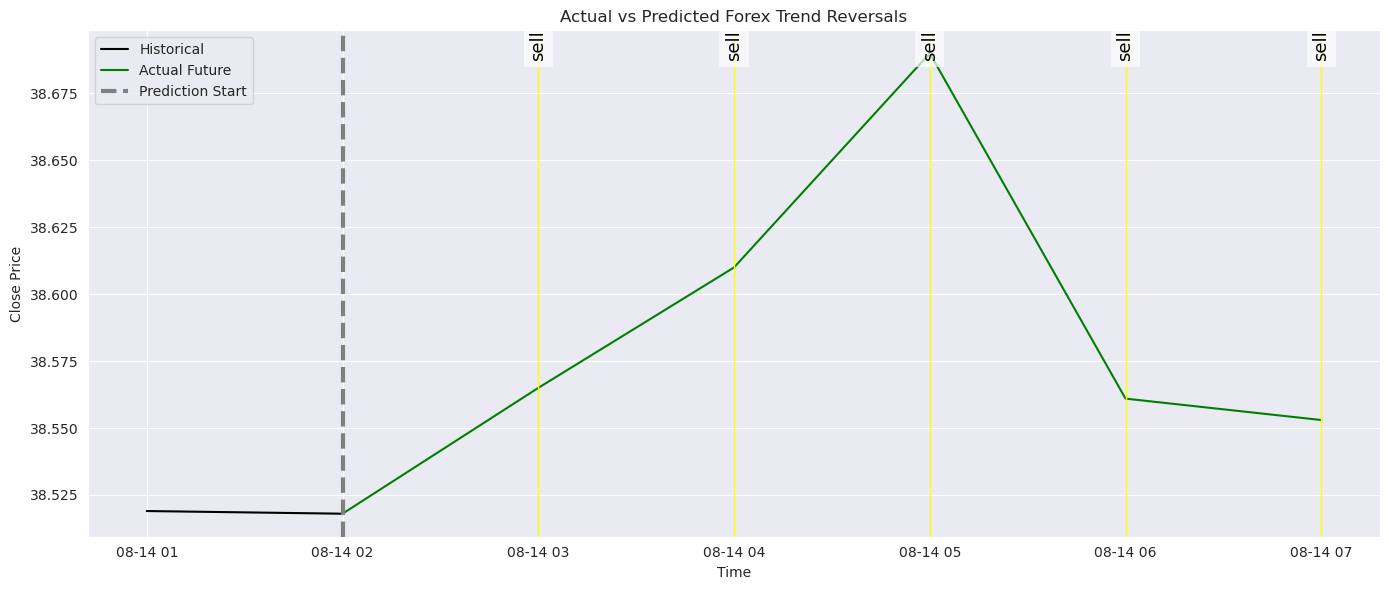

In [32]:
# --- 6. Import your plotting utility ---

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [35]:
# 11- Save Model with Comprehensive Report
from datetime import datetime
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# 1- Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 2- Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs('saved_models', exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# 3- Save model
print(f"\n[SAVING MODEL]")
model.save(model_path)
print(f"Model saved to: {model_path}")


[SAVING MODEL]
Model saved to: saved_models/model_20251216_183156.keras


In [36]:

# 4- Save scaler (IMPORTANT - needed for predictions!)
import joblib

scaler_path = os.path.join('saved_models', f'scaler_{timestamp}.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# 5- Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)
print(f"Training history saved")

# 6- Save full history as JSON so it can be reloaded later
history_json_path = os.path.join(log_dir, 'history.json')
with open(history_json_path, 'w') as f:
    json.dump(history.history, f)

print(f"Full history object saved to: {history_json_path}")

Scaler saved to: saved_models/scaler_20251216_183156.pkl
Training history saved
Full history object saved to: saved_models/model_20251216_183156_logs/history.json


In [37]:
# 7 — Save Training Loss Plot
import matplotlib.pyplot as plt

loss_plot_path = os.path.join(log_dir, "training_loss.png")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(loss_plot_path)
plt.close()

print(f"Loss plot saved to: {loss_plot_path}")

Loss plot saved to: saved_models/model_20251216_183156_logs/training_loss.png


In [38]:
# 8 — Save Accuracy Plot
acc_plot_path = os.path.join(log_dir, "training_accuracy.png")

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['accuracy'], label='Val Accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(acc_plot_path)
plt.close()

print(f"Accuracy plot saved to: {acc_plot_path}")

Accuracy plot saved to: saved_models/model_20251216_183156_logs/training_accuracy.png


In [39]:
# Confusion matrix (flattened)
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion matrix (flattened timesteps):')
print(cm)



# Path to save
cm_plot_path = os.path.join(log_dir, "confusion_matrix.png")

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['0', '1', '2'],
    yticklabels=['0', '1', '2']
)
plt.title("Confusion Matrix (Flattened Horizon)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(cm_plot_path)
plt.close()

print(f"Confusion matrix saved to: {cm_plot_path}")



Confusion matrix (flattened timesteps):
[[24930  1576 80748]
 [   43    20   887]
 [   44     3   899]]
Confusion matrix saved to: saved_models/model_20251216_183156_logs/confusion_matrix.png


In [40]:
# 1- Load model
model_path = 'saved_models/model_20251216_183156.keras'
model = keras.models.load_model(model_path)

# 2- Load scaler
scaler_path = 'saved_models/scaler_20251216_183156.pkl'
scaler = joblib.load(scaler_path)

# 3- Load history JSON
log_dir = 'saved_models/model_20251216_183156_logs'
history_json_path = os.path.join(log_dir, 'history.json')

with open(history_json_path, 'r') as f:
    history_dict = json.load(f)


# create history-like object
class ReloadedHistory:
    def __init__(self, hdict):
        self.history = hdict


history = ReloadedHistory(history_dict)

# Now you can access history just like before
print(history.history.keys())
print(history.history['loss'][:5])


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
[0.5414769649505615, 0.4454506039619446, 0.3524782061576843, 0.31371578574180603, 0.29441455006599426]
